In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
import fiona
from shapely.geometry import Point
from geopy.geocoders import Nominatim

In [2]:
all_uni_locations= pd.read_csv('../data/Colleges_and_Universities.csv')
all_uni_locations

,X,Y,OBJECTID,IPEDSID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,ALIAS,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,HOUSING,DORM_CAP,TOT_EMP,SHELTER_ID
0,-8.209134e+06,4.953591e+06,1,190752,YESHIVA OF FAR ROCKAWAY DERECH AYSON RABBINICA...,802 HICKSVILLE RD,FAR ROCKAWAY,NY,11691,5219,...,NOT AVAILABLE,24,1,-999,43,43,1,35,15,NOT AVAILABLE
1,-8.267688e+06,4.940383e+06,2,481429,UNIVERSAL TRAINING INSTITUTE,174 JEFFERSON STREET,PERTH AMBOY,NJ,8861,4106,...,NOT AVAILABLE,-2,1,-999,176,176,2,-999,15,NOT AVAILABLE
2,-7.353945e+06,2.082890e+06,3,241739,UNIVERSIDAD ANA G. MENDEZ-CUPEY CAMPUS,1399 AVE. ANA G. MENDEZ,SAN JUAN,PR,926,2602,...,UAGM CUPEY,18,3,2780,6113,8893,2,-999,1020,NOT AVAILABLE
3,-1.006191e+07,4.664997e+06,4,455071,HEALING ARTS CENTER,"10073 MANCHESTER ROAD, SUITE 100",ST. LOUIS,MO,63122,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,131,-999,131,2,-999,15,NOT AVAILABLE
4,-8.797220e+06,4.290711e+06,5,455141,AVEDA INSTITUTE-CHAPEL HILL,"201 S. ESTES DRIVE, SPACE 200 B",CHAPEL HILL,NC,27514,7001,...,NOT AVAILABLE,-2,1,-999,216,216,2,-999,25,NOT AVAILABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,-9.317151e+06,5.308190e+06,6555,494889,BAKER COLLEGE - FLINT,1050 WEST BRISTOL ROAD,FLINT,MI,48507,5508,...,NOT AVAILABLE,-2,-2,-999,-999,-999,-1,-999,-999,NOT AVAILABLE
6555,-1.082780e+07,4.536689e+06,6556,494898,WELLSPRING SCHOOL OF ALLIED HEALTH-WICHITA,"650 N CARRIAGE PARKWAY, STE 55",WICHITA,KS,67208,4501,...,NOT AVAILABLE,-2,1,-999,38,38,2,-999,14,NOT AVAILABLE
6556,-8.145887e+06,4.983035e+06,6557,494904,ACCESS CAREERS-ISLANDIA,"1930 VETERANS HIGHWAY, SUITE 10",ISLANDIA,NY,11749,1599,...,NOT AVAILABLE,-2,1,43,20,63,2,-999,18,NOT AVAILABLE
6557,-1.304572e+07,3.865065e+06,6558,494913,FRANCISCAN SCHOOL OF THEOLOGY - SAN DIEGO,5998 ALCALA PARK,SAN DIEGO,CA,92110,2492,...,NOT AVAILABLE,-2,-2,-999,-999,-999,-1,-999,-999,NOT AVAILABLE


In [3]:
private_public = pd.read_csv('../data/school_data/public_private.csv')
private_public 

,Unnamed: 0,Institution,State,Designation,Designation.1
0,100654,Alabama A&M University,AL,1,4-year public
1,100724,Alabama State University,AL,1,4-year public
2,102030,Bishop State Community College,AL,2,2-year public
3,101240,Gadsden State Community College,AL,2,2-year public
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public
...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private
97,234137,Virginia University of Lynchburg,VA,3,4-year private
98,237215,Bluefield State College,WV,1,4-year public
99,237899,West Virginia State University,WV,1,4-year public


In [4]:
hbcu_merged=pd.merge(private_public, all_uni_locations, left_on='Unnamed: 0', right_on='IPEDSID')
hbcu_merged

,Unnamed: 0,Institution,State,Designation,Designation.1,X,Y,OBJECTID,IPEDSID,NAME,...,ALIAS,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,HOUSING,DORM_CAP,TOT_EMP,SHELTER_ID
0,100654,Alabama A&M University,AL,1,4-year public,-9.636762e+06,4.134481e+06,5132,100654,ALABAMA A & M UNIVERSITY,...,AAMU,18,3,728,5249,5977,1,3220,918,NOT AVAILABLE
1,100724,Alabama State University,AL,1,4-year public,-9.606391e+06,3.811228e+06,2528,100724,ALABAMA STATE UNIVERSITY,...,NOT AVAILABLE,19,2,465,3607,4072,1,2079,919,NOT AVAILABLE
2,102030,Bishop State Community College,AL,2,2-year public,-9.802458e+06,3.593069e+06,27,102030,BISHOP STATE COMMUNITY COLLEGE,...,NOT AVAILABLE,8,2,1421,755,2176,2,-999,290,NOT AVAILABLE
3,101240,Gadsden State Community College,AL,2,2-year public,-9.572508e+06,4.027710e+06,3851,101240,GADSDEN STATE COMMUNITY COLLEGE,...,GSCC | GADSDEN STATE | GADSDEN COMMUNITY COLLEGE,8,2,2077,1916,3993,1,110,538,10812401
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,-9.611665e+06,3.809356e+06,625,102313,H COUNCILL TRENHOLM STATE COMMUNITY COLLEGE,...,TRENHOLM STATE,8,2,884,642,1526,2,-999,188,NOT AVAILABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,-8.621738e+06,4.517615e+06,4393,234164,VIRGINIA UNION UNIVERSITY,...,VUU,21,2,156,1360,1516,1,693,359,NOT AVAILABLE
97,234137,Virginia University of Lynchburg,VA,3,4-year private,-8.811107e+06,4.494328e+06,3317,234137,VIRGINIA UNIVERSITY OF LYNCHBURG,...,NOT AVAILABLE,24,1,36,208,244,1,168,64,NOT AVAILABLE
98,237215,Bluefield State College,WV,1,4-year public,-9.043488e+06,4.476211e+06,2521,237215,BLUEFIELD STATE COLLEGE,...,NOT AVAILABLE,22,2,294,949,1243,2,-999,195,NOT AVAILABLE
99,237899,West Virginia State University,WV,1,4-year public,-9.102374e+06,4.633105e+06,5474,237899,WEST VIRGINIA STATE UNIVERSITY,...,WVSU STATE,21,2,2078,1560,3638,1,369,342,NOT AVAILABLE


In [5]:
occ_wages = pd.read_excel('../data/oesm22st/oesm22st/state_M2022_dl.xlsx',sheet_name='All May 2022 data')
occ_wages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37569 entries, 0 to 37568
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          37569 non-null  int64  
 1   AREA_TITLE    37569 non-null  object 
 2   AREA_TYPE     37569 non-null  int64  
 3   PRIM_STATE    37569 non-null  object 
 4   NAICS         37569 non-null  int64  
 5   NAICS_TITLE   37569 non-null  object 
 6   I_GROUP       37569 non-null  object 
 7   OWN_CODE      37569 non-null  int64  
 8   OCC_CODE      37569 non-null  object 
 9   OCC_TITLE     37569 non-null  object 
 10  O_GROUP       37569 non-null  object 
 11  TOT_EMP       37569 non-null  object 
 12  EMP_PRSE      37569 non-null  object 
 13  JOBS_1000     37569 non-null  object 
 14  LOC_QUOTIENT  37569 non-null  object 
 15  PCT_TOTAL     0 non-null      float64
 16  PCT_RPT       0 non-null      float64
 17  H_MEAN        37569 non-null  object 
 18  A_MEAN        37569 non-nu

In [6]:
wages_mean_state_occ_fam= occ_wages[occ_wages['O_GROUP'] == 'major'][['AREA_TITLE', 'OCC_TITLE','A_MEAN']]
wages_mean_state_occ_fam.reset_index(drop=True)

,AREA_TITLE,OCC_TITLE,A_MEAN
0,Alabama,Management Occupations,110500
1,Alabama,Business and Financial Operations Occupations,76490
2,Alabama,Computer and Mathematical Occupations,92440
3,Alabama,Architecture and Engineering Occupations,97910
4,Alabama,"Life, Physical, and Social Science Occupations",69810
...,...,...,...
1183,Virgin Islands,"Farming, Fishing, and Forestry Occupations",38810
1184,Virgin Islands,Construction and Extraction Occupations,49700
1185,Virgin Islands,"Installation, Maintenance, and Repair Occupations",46710
1186,Virgin Islands,Production Occupations,40000


In [7]:
wages_mean_state_occ_fam.A_MEAN=wages_mean_state_occ_fam.A_MEAN.astype(int).fillna(0.00)
wages_mean_state_occ_fam=wages_mean_state_occ_fam.reset_index(drop=True)
wages_mean_state_occ_fam

,AREA_TITLE,OCC_TITLE,A_MEAN
0,Alabama,Management Occupations,110500
1,Alabama,Business and Financial Operations Occupations,76490
2,Alabama,Computer and Mathematical Occupations,92440
3,Alabama,Architecture and Engineering Occupations,97910
4,Alabama,"Life, Physical, and Social Science Occupations",69810
...,...,...,...
1183,Virgin Islands,"Farming, Fishing, and Forestry Occupations",38810
1184,Virgin Islands,Construction and Extraction Occupations,49700
1185,Virgin Islands,"Installation, Maintenance, and Repair Occupations",46710
1186,Virgin Islands,Production Occupations,40000


In [8]:
states= {'Alabama', 'Arkansas', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland',
        'Missouri', 'Mississippi', 'North Carolina', 'Ohio', 'Oklahoma','Pennsylvania', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 
        'Virgin Islands', 'West Virginia'}
wages_occ_loc= wages_mean_state_occ_fam.loc[wages_mean_state_occ_fam['AREA_TITLE'].isin(states)].copy()
wages_occ_loc

,AREA_TITLE,OCC_TITLE,A_MEAN
0,Alabama,Management Occupations,110500
1,Alabama,Business and Financial Operations Occupations,76490
2,Alabama,Computer and Mathematical Occupations,92440
3,Alabama,Architecture and Engineering Occupations,97910
4,Alabama,"Life, Physical, and Social Science Occupations",69810
...,...,...,...
1183,Virgin Islands,"Farming, Fishing, and Forestry Occupations",38810
1184,Virgin Islands,Construction and Extraction Occupations,49700
1185,Virgin Islands,"Installation, Maintenance, and Repair Occupations",46710
1186,Virgin Islands,Production Occupations,40000


source: https://hub.arcgis.com/datasets/1b02c87f62d24508970dc1a6df80c98e/explore?showTable=true

In [9]:
states_shp= gpd.read_file('../data/cb_2018_us_state_500k/States_shapefile-shp/States_shapefile.shp')
states_shp

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."
5,6,ECOMAP,CO,COLORADO,F,924,"POLYGON ((-102.04446 37.64147, -102.04201 37.3..."
6,7,SIMS,CT,CONNECTICUT,F,925,"POLYGON ((-73.53039 41.52275, -73.51715 41.665..."
7,8,None,DE,DELAWARE,P,926,"POLYGON ((-75.70707 38.55759, -75.71071 38.649..."
8,9,None,DC,DISTRICT OF COLUMBIA,P,927,"POLYGON ((-77.00793 38.96667, -76.91090 38.890..."
9,10,None,FL,FLORIDA,P,928,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ..."


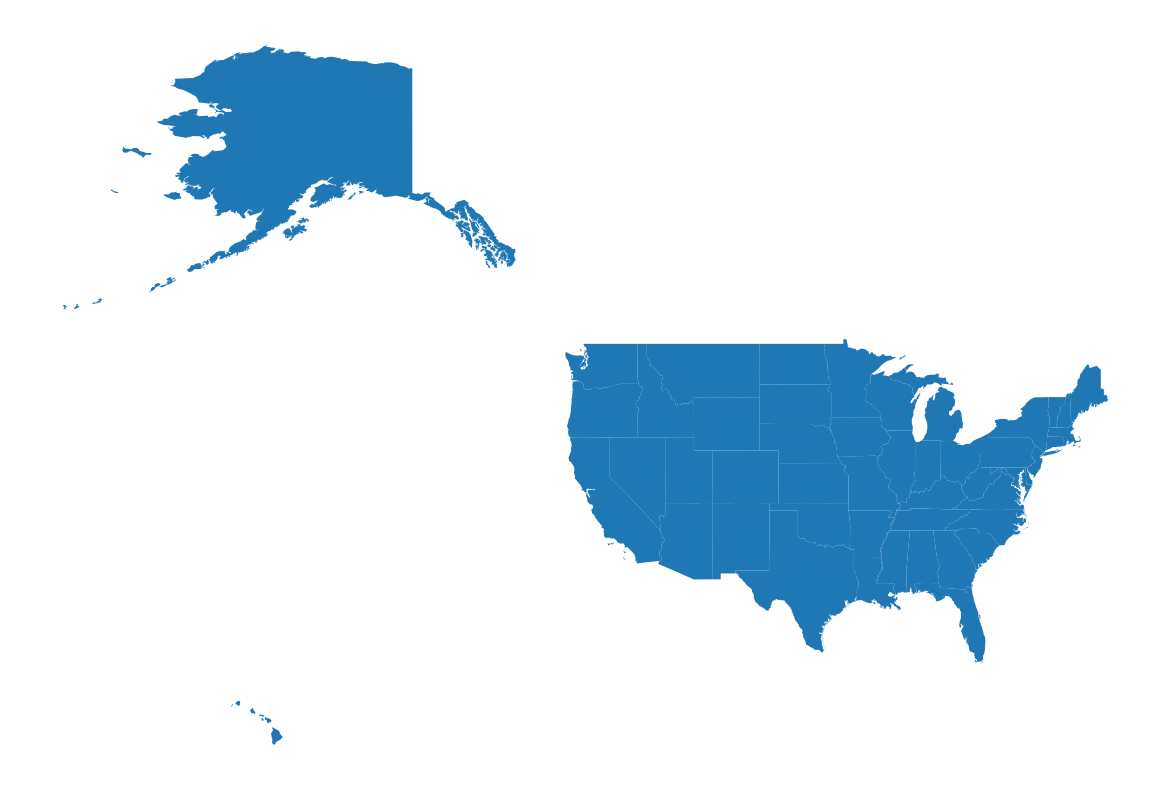

In [10]:
fig, ax= plt.subplots(figsize=(20,10))
states_shp.plot(ax=ax)
ax.axis('off');

In [11]:
unemp= pd.read_csv('../data/unemployment.csv')
unemp

,State,STATE,Unemployment_rate_2022
0,North Dakota,NORTH DAKOTA,2.1
1,South Dakota,SOUTH DAKOTA,2.1
2,Nebraska,NEBRASKA,2.3
3,Utah,UTAH,2.3
4,Missouri,MISSOURI,2.5
5,New Hampshire,NEW HAMPSHIRE,2.5
6,Alabama,ALABAMA,2.6
7,Montana,MONTANA,2.6
8,Vermont,VERMONT,2.6
9,Idaho,IDAHO,2.7


In [12]:
umemp_shp=pd.merge(states_shp, unemp, left_on='State_Name', right_on='STATE')
umemp_shp

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,State,STATE,Unemployment_rate_2022
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",Alabama,ALABAMA,2.6
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",Alaska,ALASKA,4.0
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",Arizona,ARIZONA,3.8
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",Arkansas,ARKANSAS,3.3
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",California,CALIFORNIA,4.2
5,6,ECOMAP,CO,COLORADO,F,924,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",Colorado,COLORADO,3.0
6,7,SIMS,CT,CONNECTICUT,F,925,"POLYGON ((-73.53039 41.52275, -73.51715 41.665...",Connecticut,CONNECTICUT,4.2
7,8,None,DE,DELAWARE,P,926,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",Delaware,DELAWARE,4.5
8,9,None,DC,DISTRICT OF COLUMBIA,P,927,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",District of Columbia,DISTRICT OF COLUMBIA,4.7
9,10,None,FL,FLORIDA,P,928,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",Florida,FLORIDA,2.9


In [13]:
umemp_shp.drop([1, 2, 4, 5, 6, 11, 12, 13, 14, 15, 16, 19, 21, 22, 23, 26, 27, 28, 
                 29, 30, 31, 32, 34, 37, 39, 41, 44, 45, 47, 49, 50])

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,State,STATE,Unemployment_rate_2022
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",Alabama,ALABAMA,2.6
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",Arkansas,ARKANSAS,3.3
7,8,None,DE,DELAWARE,P,926,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",Delaware,DELAWARE,4.5
8,9,None,DC,DISTRICT OF COLUMBIA,P,927,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",District of Columbia,DISTRICT OF COLUMBIA,4.7
9,10,None,FL,FLORIDA,P,928,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",Florida,FLORIDA,2.9
10,11,None,GA,GEORGIA,N,929,"MULTIPOLYGON (((-85.13016 31.77885, -85.13156 ...",Georgia,GEORGIA,3.0
17,18,KY-TEMPO,KY,KENTUCKY,F,936,"MULTIPOLYGON (((-86.51067 36.65507, -86.77054 ...",Kentucky,KENTUCKY,3.9
18,19,None,LA,LOUISIANA,P,937,"MULTIPOLYGON (((-93.70752 30.23958, -93.69938 ...",Louisiana,LOUISIANA,3.7
20,21,None,MD,MARYLAND,P,939,"MULTIPOLYGON (((-75.71071 38.64967, -75.70707 ...",Maryland,MARYLAND,3.2
24,25,MS-ENSITE,MS,MISSISSIPPI,F,943,"POLYGON ((-88.45080 31.43562, -88.43456 31.120...",Mississippi,MISSISSIPPI,3.9


In [14]:
dropping=[0,1,4,5,7,8]
umemp_shp.drop(umemp_shp.columns[dropping], axis =1, inplace=True)

In [15]:
unemp_shp2=umemp_shp
unemp_shp2

,State_Code,State_Name,geometry,Unemployment_rate_2022
0,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6
1,AK,ALASKA,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",4.0
2,AZ,ARIZONA,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",3.8
3,AR,ARKANSAS,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.3
4,CA,CALIFORNIA,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",4.2
5,CO,COLORADO,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",3.0
6,CT,CONNECTICUT,"POLYGON ((-73.53039 41.52275, -73.51715 41.665...",4.2
7,DE,DELAWARE,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",4.5
8,DC,DISTRICT OF COLUMBIA,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",4.7
9,FL,FLORIDA,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",2.9


In [16]:
new1=unemp_shp2.drop([1, 2, 4, 5, 6, 11, 12, 13, 14, 15, 16, 19, 21, 22, 23, 26, 27, 28, 
                 29, 30, 31, 32, 34, 37, 39, 41, 44, 45, 47, 49, 50])
new1

,State_Code,State_Name,geometry,Unemployment_rate_2022
0,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6
3,AR,ARKANSAS,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.3
7,DE,DELAWARE,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",4.5
8,DC,DISTRICT OF COLUMBIA,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",4.7
9,FL,FLORIDA,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",2.9
10,GA,GEORGIA,"MULTIPOLYGON (((-85.13016 31.77885, -85.13156 ...",3.0
17,KY,KENTUCKY,"MULTIPOLYGON (((-86.51067 36.65507, -86.77054 ...",3.9
18,LA,LOUISIANA,"MULTIPOLYGON (((-93.70752 30.23958, -93.69938 ...",3.7
20,MD,MARYLAND,"MULTIPOLYGON (((-75.71071 38.64967, -75.70707 ...",3.2
24,MS,MISSISSIPPI,"POLYGON ((-88.45080 31.43562, -88.43456 31.120...",3.9


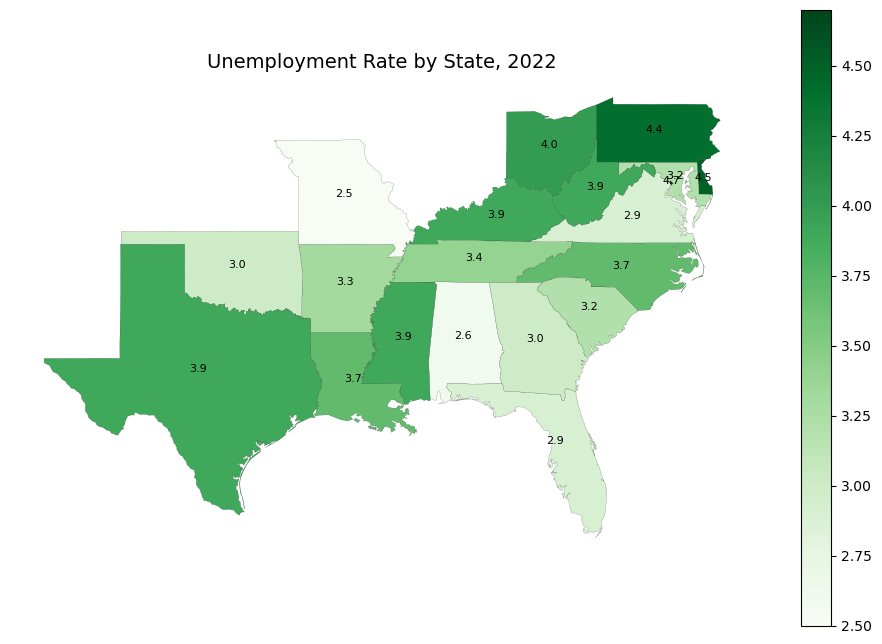

In [17]:
fig, ax= plt.subplots(figsize=(12,8))
new1.plot(column= 'Unemployment_rate_2022',
               edgecolor = 'black',
               cmap='Greens',
               legend= True,
               linewidth=0.1,
               ax=ax)
for idx, row in new1.iterrows():
    plt.annotate(text=row['Unemployment_rate_2022'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
   
plt.title('Unemployment Rate by State, 2022', fontsize = 14)
ax.axis('off');

In [18]:
wages_occ_loc.loc[wages_occ_loc['AREA_TITLE']=='Alabama']

,AREA_TITLE,OCC_TITLE,A_MEAN
0,Alabama,Management Occupations,110500
1,Alabama,Business and Financial Operations Occupations,76490
2,Alabama,Computer and Mathematical Occupations,92440
3,Alabama,Architecture and Engineering Occupations,97910
4,Alabama,"Life, Physical, and Social Science Occupations",69810
5,Alabama,Community and Social Service Occupations,47000
6,Alabama,Legal Occupations,100320
7,Alabama,Educational Instruction and Library Occupations,53940
8,Alabama,"Arts, Design, Entertainment, Sports, and Media...",51980
9,Alabama,Healthcare Practitioners and Technical Occupat...,75180


In [19]:
bus_occ = wages_occ_loc[(wages_occ_loc['OCC_TITLE'] == "Management Occupations") | (wages_occ_loc['OCC_TITLE'] == "Business and Financial Operations Occupations") 
| (wages_occ_loc['OCC_TITLE'] == "Office and Administrative Support Occupations")]
bus_occ2= bus_occ.copy()
bus_occ2['Occ_Family']= 'Business/Financial/Management'
bus_occ2.reset_index(inplace=True)
bus_occ2

,index,AREA_TITLE,OCC_TITLE,A_MEAN,Occ_Family
0,0,Alabama,Management Occupations,110500,Business/Financial/Management
1,1,Alabama,Business and Financial Operations Occupations,76490,Business/Financial/Management
2,16,Alabama,Office and Administrative Support Occupations,38680,Business/Financial/Management
3,66,Arkansas,Management Occupations,93480,Business/Financial/Management
4,67,Arkansas,Business and Financial Operations Occupations,70190,Business/Financial/Management
...,...,...,...,...,...
58,1057,West Virginia,Business and Financial Operations Occupations,69410,Business/Financial/Management
59,1072,West Virginia,Office and Administrative Support Occupations,37620,Business/Financial/Management
60,1166,Virgin Islands,Management Occupations,85270,Business/Financial/Management
61,1167,Virgin Islands,Business and Financial Operations Occupations,60380,Business/Financial/Management


In [20]:
health_occ= wages_occ_loc[(wages_occ_loc['OCC_TITLE'] == "Healthcare Practitioners and Technical Occupations") 
| (wages_occ_loc['OCC_TITLE'] == "Healthcare Support Occupations")]
health_occ2=health_occ.copy()
health_occ2['Occ_Family'] ='Healthcare Practitioners/Support Staff'
health_occ2.reset_index(inplace=True)
health_occ2

,index,AREA_TITLE,OCC_TITLE,A_MEAN,Occ_Family
0,9,Alabama,Healthcare Practitioners and Technical Occupat...,75180,Healthcare Practitioners/Support Staff
1,10,Alabama,Healthcare Support Occupations,29720,Healthcare Practitioners/Support Staff
2,75,Arkansas,Healthcare Practitioners and Technical Occupat...,74720,Healthcare Practitioners/Support Staff
3,76,Arkansas,Healthcare Support Occupations,31270,Healthcare Practitioners/Support Staff
4,163,Delaware,Healthcare Practitioners and Technical Occupat...,94320,Healthcare Practitioners/Support Staff
5,164,Delaware,Healthcare Support Occupations,34800,Healthcare Practitioners/Support Staff
6,185,District of Columbia,Healthcare Practitioners and Technical Occupat...,109450,Healthcare Practitioners/Support Staff
7,186,District of Columbia,Healthcare Support Occupations,39850,Healthcare Practitioners/Support Staff
8,207,Florida,Healthcare Practitioners and Technical Occupat...,89800,Healthcare Practitioners/Support Staff
9,208,Florida,Healthcare Support Occupations,35790,Healthcare Practitioners/Support Staff


In [21]:
edu_occ= wages_occ_loc[(wages_occ_loc['OCC_TITLE'] == "Educational Instruction and Library Occupations")]
edu_occ2= edu_occ.copy()
edu_occ2['Occ_Family']= 'Educational Instruction/Librarian'
edu_occ2.reset_index(inplace=True)
edu_occ2

,index,AREA_TITLE,OCC_TITLE,A_MEAN,Occ_Family
0,7,Alabama,Educational Instruction and Library Occupations,53940,Educational Instruction/Librarian
1,73,Arkansas,Educational Instruction and Library Occupations,51260,Educational Instruction/Librarian
2,161,Delaware,Educational Instruction and Library Occupations,59800,Educational Instruction/Librarian
3,183,District of Columbia,Educational Instruction and Library Occupations,79490,Educational Instruction/Librarian
4,205,Florida,Educational Instruction and Library Occupations,55820,Educational Instruction/Librarian
5,227,Georgia,Educational Instruction and Library Occupations,58300,Educational Instruction/Librarian
6,381,Kentucky,Educational Instruction and Library Occupations,52890,Educational Instruction/Librarian
7,403,Louisiana,Educational Instruction and Library Occupations,51980,Educational Instruction/Librarian
8,447,Maryland,Educational Instruction and Library Occupations,71300,Educational Instruction/Librarian
9,535,Mississippi,Educational Instruction and Library Occupations,47940,Educational Instruction/Librarian


In [22]:
cat_occ= pd.concat([edu_occ2, health_occ2, bus_occ2], axis=0)
cat_occ

,index,AREA_TITLE,OCC_TITLE,A_MEAN,Occ_Family
0,7,Alabama,Educational Instruction and Library Occupations,53940,Educational Instruction/Librarian
1,73,Arkansas,Educational Instruction and Library Occupations,51260,Educational Instruction/Librarian
2,161,Delaware,Educational Instruction and Library Occupations,59800,Educational Instruction/Librarian
3,183,District of Columbia,Educational Instruction and Library Occupations,79490,Educational Instruction/Librarian
4,205,Florida,Educational Instruction and Library Occupations,55820,Educational Instruction/Librarian
...,...,...,...,...,...
58,1057,West Virginia,Business and Financial Operations Occupations,69410,Business/Financial/Management
59,1072,West Virginia,Office and Administrative Support Occupations,37620,Business/Financial/Management
60,1166,Virgin Islands,Management Occupations,85270,Business/Financial/Management
61,1167,Virgin Islands,Business and Financial Operations Occupations,60380,Business/Financial/Management


In [23]:
cat_occ=cat_occ.drop(cat_occ.columns[0], axis=1)
cat_occ

,AREA_TITLE,OCC_TITLE,A_MEAN,Occ_Family
0,Alabama,Educational Instruction and Library Occupations,53940,Educational Instruction/Librarian
1,Arkansas,Educational Instruction and Library Occupations,51260,Educational Instruction/Librarian
2,Delaware,Educational Instruction and Library Occupations,59800,Educational Instruction/Librarian
3,District of Columbia,Educational Instruction and Library Occupations,79490,Educational Instruction/Librarian
4,Florida,Educational Instruction and Library Occupations,55820,Educational Instruction/Librarian
...,...,...,...,...
58,West Virginia,Business and Financial Operations Occupations,69410,Business/Financial/Management
59,West Virginia,Office and Administrative Support Occupations,37620,Business/Financial/Management
60,Virgin Islands,Management Occupations,85270,Business/Financial/Management
61,Virgin Islands,Business and Financial Operations Occupations,60380,Business/Financial/Management


In [24]:
grouped_occ= cat_occ.groupby(['AREA_TITLE', 'Occ_Family'])['A_MEAN'].mean()
grouped_occ= grouped_occ.to_frame()

In [25]:
grouped_occ.reset_index(drop=False, inplace=True)

In [26]:
grouped_occ['A_MEAN']= grouped_occ['A_MEAN'].round(decimals=2)
grouped_occ

,AREA_TITLE,Occ_Family,A_MEAN
0,Alabama,Business/Financial/Management,75223.33
1,Alabama,Educational Instruction/Librarian,53940.00
2,Alabama,Healthcare Practitioners/Support Staff,52450.00
3,Arkansas,Business/Financial/Management,67603.33
4,Arkansas,Educational Instruction/Librarian,51260.00
...,...,...,...
58,Virginia,Educational Instruction/Librarian,64730.00
59,Virginia,Healthcare Practitioners/Support Staff,63195.00
60,West Virginia,Business/Financial/Management,68370.00
61,West Virginia,Educational Instruction/Librarian,53820.00


In [27]:
grouped_occ2= grouped_occ.groupby(['Occ_Family'])['A_MEAN'].mean()
grouped_occ2= grouped_occ2.to_frame()
grouped_occ2.reset_index(drop=False, inplace=True)

In [28]:
grouped_occ2['A_MEAN']= grouped_occ2['A_MEAN'].round(decimals=2)
grouped_occ2

,Occ_Family,A_MEAN
0,Business/Financial/Management,79456.19
1,Educational Instruction/Librarian,57168.10
2,Healthcare Practitioners/Support Staff,60030.71


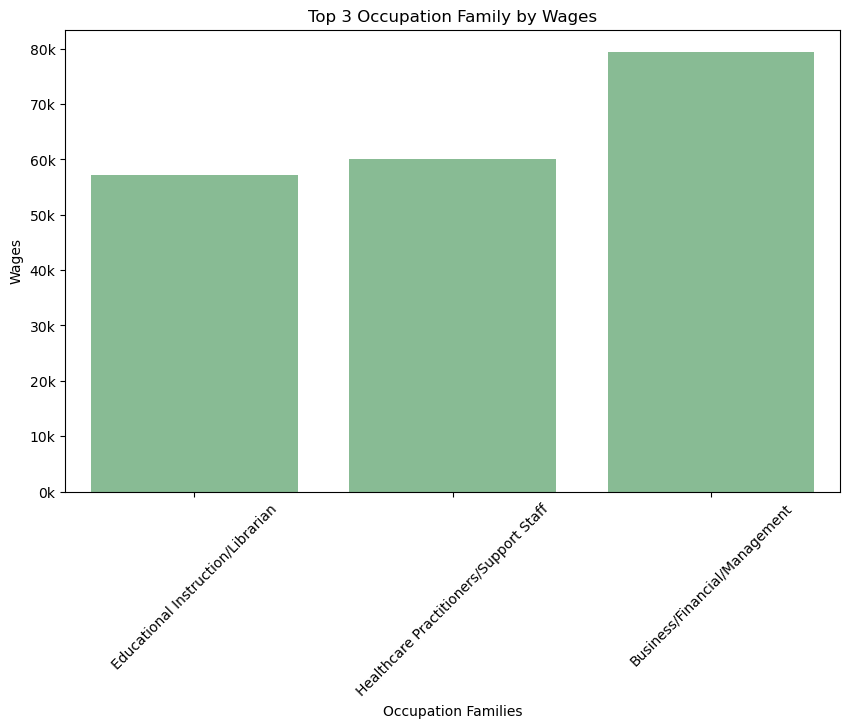

In [29]:
from matplotlib.ticker import FuncFormatter

grouped_occ2 = grouped_occ2.sort_values(by='A_MEAN')
plt.figure(figsize=(10, 6))

sns.barplot(data=grouped_occ2, x='Occ_Family', y='A_MEAN', color='#7FC48F')
plt.xticks(rotation=45, ha='center')
plt.xlabel('Occupation Families')
plt.ylabel('Wages')
plt.title('Top 3 Occupation Family by Wages')

def thousands_formatter(x, pos):
    return f'{x / 1000:.0f}k'

formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.savefig('../maps/top3occ.png', bbox_inches='tight', dpi=400)
plt.show()

In [30]:
grouped_occ3= grouped_occ.groupby(['AREA_TITLE'])['A_MEAN'].mean()
grouped_occ3= grouped_occ3.to_frame()
grouped_occ3.reset_index(drop=False, inplace=True)
grouped_occ3['A_MEAN']= grouped_occ3['A_MEAN'].round(decimals=2)
grouped_occ3

,AREA_TITLE,A_MEAN
0,Alabama,60537.78
1,Arkansas,57286.11
2,Delaware,73858.89
3,District of Columbia,88126.67
4,Florida,66468.33
5,Georgia,68082.22
6,Kentucky,61356.11
7,Louisiana,59648.89
8,Maryland,78566.67
9,Mississippi,54688.33


In [31]:
grouped_occ3['AREA_TITLE']=grouped_occ3['AREA_TITLE'].str.upper()
grouped_occ3

,AREA_TITLE,A_MEAN
0,ALABAMA,60537.78
1,ARKANSAS,57286.11
2,DELAWARE,73858.89
3,DISTRICT OF COLUMBIA,88126.67
4,FLORIDA,66468.33
5,GEORGIA,68082.22
6,KENTUCKY,61356.11
7,LOUISIANA,59648.89
8,MARYLAND,78566.67
9,MISSISSIPPI,54688.33


In [32]:
wag_shp=pd.merge(new1, grouped_occ3, left_on='State_Name', right_on='AREA_TITLE')
wag_shp

,State_Code,State_Name,geometry,Unemployment_rate_2022,AREA_TITLE,A_MEAN
0,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,ALABAMA,60537.78
1,AR,ARKANSAS,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.3,ARKANSAS,57286.11
2,DE,DELAWARE,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",4.5,DELAWARE,73858.89
3,DC,DISTRICT OF COLUMBIA,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",4.7,DISTRICT OF COLUMBIA,88126.67
4,FL,FLORIDA,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",2.9,FLORIDA,66468.33
5,GA,GEORGIA,"MULTIPOLYGON (((-85.13016 31.77885, -85.13156 ...",3.0,GEORGIA,68082.22
6,KY,KENTUCKY,"MULTIPOLYGON (((-86.51067 36.65507, -86.77054 ...",3.9,KENTUCKY,61356.11
7,LA,LOUISIANA,"MULTIPOLYGON (((-93.70752 30.23958, -93.69938 ...",3.7,LOUISIANA,59648.89
8,MD,MARYLAND,"MULTIPOLYGON (((-75.71071 38.64967, -75.70707 ...",3.2,MARYLAND,78566.67
9,MS,MISSISSIPPI,"POLYGON ((-88.45080 31.43562, -88.43456 31.120...",3.9,MISSISSIPPI,54688.33


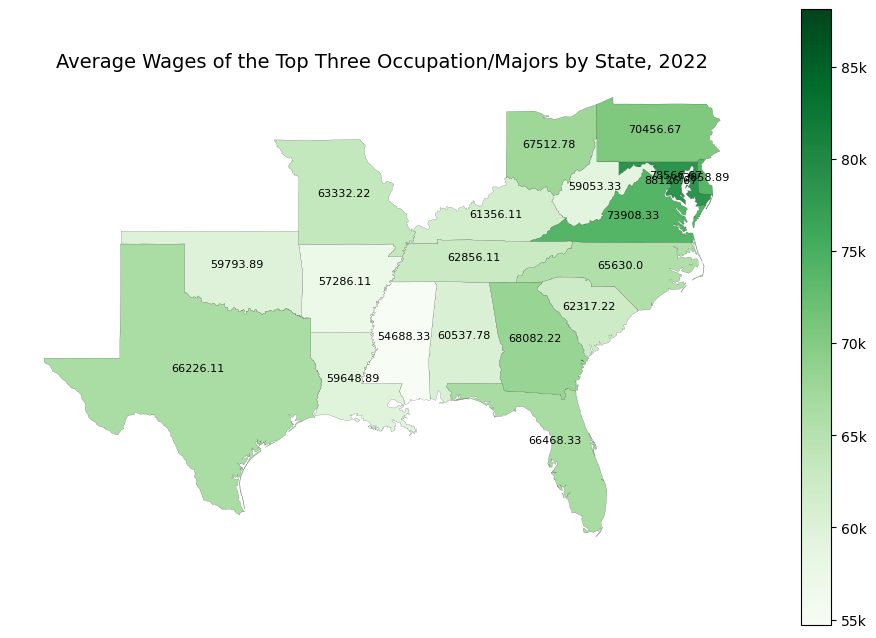

In [33]:
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.ticker import FuncFormatter

fig, ax= plt.subplots(figsize=(12,8))
wag_shp.plot(column= 'A_MEAN',
               edgecolor = 'black',
               cmap='Greens',
               legend= True,
               linewidth=0.1,
               ax=ax)
for idx, row in wag_shp.iterrows():
    plt.annotate(text=row['A_MEAN'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
   
plt.title('Average Wages of the Top Three Occupation/Majors by State, 2022', fontsize = 14)
ax.axis('off')

def thousands_formatter(x, pos):
    return f'{x / 1000:.0f}k'

cbar = ax.get_figure().get_axes()[1]
formatter = FuncFormatter(thousands_formatter)
cbar.yaxis.set_major_formatter(formatter)

In [34]:
unemp_shp2

,State_Code,State_Name,geometry,Unemployment_rate_2022
0,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6
1,AK,ALASKA,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",4.0
2,AZ,ARIZONA,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",3.8
3,AR,ARKANSAS,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.3
4,CA,CALIFORNIA,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",4.2
5,CO,COLORADO,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",3.0
6,CT,CONNECTICUT,"POLYGON ((-73.53039 41.52275, -73.51715 41.665...",4.2
7,DE,DELAWARE,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",4.5
8,DC,DISTRICT OF COLUMBIA,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",4.7
9,FL,FLORIDA,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",2.9


In [37]:
occ_wages['AREA_TITLE']= occ_wages['AREA_TITLE'].str.upper()
occ_wages

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,1,ALABAMA,2,AL,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,18.5,28.94,43.25,21580,28030,38470,60190,89950,NaN,NaN
1,1,ALABAMA,2,AL,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,46.12,63.53,86.89,47680,66210,95940,132150,180730,NaN,NaN
2,1,ALABAMA,2,AL,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,65.83,90.64,#,50920,108470,136930,188530,#,NaN,NaN
3,1,ALABAMA,2,AL,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,47.17,71.64,105.19,44530,65280,98120,149010,218800,NaN,NaN
4,1,ALABAMA,2,AL,0,Cross-industry,cross-industry,1235,11-1031,Legislators,...,*,*,*,17080,18130,20320,35730,57060,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37564,78,VIRGIN ISLANDS,3,VI,0,Cross-industry,cross-industry,1235,53-7051,Industrial Truck and Tractor Operators,...,15.15,17.63,18.24,25860,29010,31520,36680,37940,NaN,NaN
37565,78,VIRGIN ISLANDS,3,VI,0,Cross-industry,cross-industry,1235,53-7061,Cleaners of Vehicles and Equipment,...,13.92,14.86,16.63,23360,28510,28950,30910,34590,NaN,NaN
37566,78,VIRGIN ISLANDS,3,VI,0,Cross-industry,cross-industry,1235,53-7062,"Laborers and Freight, Stock, and Material Move...",...,13.73,15.66,19.19,24520,26640,28550,32570,39920,NaN,NaN
37567,78,VIRGIN ISLANDS,3,VI,0,Cross-industry,cross-industry,1235,53-7064,"Packers and Packagers, Hand",...,12.59,13.79,17.31,22710,22940,26180,28690,36000,NaN,NaN


In [40]:
occ_wage_unemp= pd.merge(new1, occ_wages, left_on='State_Name', right_on='AREA_TITLE', how='left')
occ_wage_unemp

,State_Code,State_Name,geometry,Unemployment_rate_2022,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,1,ALABAMA,2,AL,0,Cross-industry,...,18.5,28.94,43.25,21580,28030,38470,60190,89950,NaN,NaN
1,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,1,ALABAMA,2,AL,0,Cross-industry,...,46.12,63.53,86.89,47680,66210,95940,132150,180730,NaN,NaN
2,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,1,ALABAMA,2,AL,0,Cross-industry,...,65.83,90.64,#,50920,108470,136930,188530,#,NaN,NaN
3,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,1,ALABAMA,2,AL,0,Cross-industry,...,47.17,71.64,105.19,44530,65280,98120,149010,218800,NaN,NaN
4,AL,ALABAMA,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2.6,1,ALABAMA,2,AL,0,Cross-industry,...,*,*,*,17080,18130,20320,35730,57060,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14781,WV,WEST VIRGINIA,"POLYGON ((-79.23166 38.48050, -79.27236 38.437...",3.9,54,WEST VIRGINIA,2,WV,0,Cross-industry,...,32.38,35.79,43.41,50440,57000,67360,74430,90300,NaN,NaN
14782,WV,WEST VIRGINIA,"POLYGON ((-79.23166 38.48050, -79.27236 38.437...",3.9,54,WEST VIRGINIA,2,WV,0,Cross-industry,...,25.12,26.91,28.08,40170,51880,52260,55970,58410,NaN,NaN
14783,WV,WEST VIRGINIA,"POLYGON ((-79.23166 38.48050, -79.27236 38.437...",3.9,54,WEST VIRGINIA,2,WV,0,Cross-industry,...,17.43,22.12,28.88,30210,35310,36250,46010,60070,NaN,NaN
14784,WV,WEST VIRGINIA,"POLYGON ((-79.23166 38.48050, -79.27236 38.437...",3.9,54,WEST VIRGINIA,2,WV,0,Cross-industry,...,14.58,16.41,19.66,18200,23660,30320,34130,40890,NaN,NaN


In [41]:
occ_wage_unemp.to_csv('../power_bi/occ_wage_unemp.csv')